# 1. Facebook Prophet Testing

## I - Setup

In [1]:
# Import of librairies

import mysql.connector as mariadb
import pandas as pd
from fbprophet import Prophet
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Importing plotly failed. Interactive plots will not work.


In [2]:
class sql_query:
    def __init__(self, credentials_path):
        self.db_credentials = pd.read_csv(credentials_path, index_col="Field")
      
    
    def __call__(self, query):
        
        mariadb_connection = mariadb.connect(
            user=self.db_credentials.loc["user"][0],
            password=self.db_credentials.loc["password"][0],
            host=self.db_credentials.loc["host"][0],
            port=3306,
            db = "db_velib")
        
        self.cursor = mariadb_connection.cursor()
    
        cursor = self.cursor
        cursor.execute(query)
        field_names = [i[0] for i in cursor.description]
        df = pd.DataFrame(cursor, columns=field_names)
        return df

## II. Adaptation pipeline

In [3]:
# Taking data from  station 9034 - Madeleine

request = sql_query("../../aws_mariadb_crendentials.csv")

query = """
SELECT DISTINCT * FROM velib_realtime
WHERE station_id = 9034
AND date_of_update > DATE("2020-05-05")
ORDER BY date_of_update ASC
"""

df_full = request(query)

In [4]:
df_full.head()

,station_id,operational_station,nb_free_docks,nb_total_free_bikes,nb_free_mechanical_bikes,nb_free_electrical_bikes,payment_totem,bike_return_possible,data_actualisation,date_of_update
0,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:01:00
1,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:02:00
2,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:03:00
3,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:04:00
4,9034,OUI,20,2,1,1,OUI,OUI,2020-05-04 23:26:49,2020-05-05 00:05:00


In [5]:
df = df_full[['date_of_update','nb_free_docks']]

# Adopting FB Prophet terminology for easier use
df.columns = ['ds','y']
df.head()

,ds,y
0,2020-05-05 00:01:00,20
1,2020-05-05 00:02:00,20
2,2020-05-05 00:03:00,20
3,2020-05-05 00:04:00,20
4,2020-05-05 00:05:00,20


In [6]:
import seaborn as sns

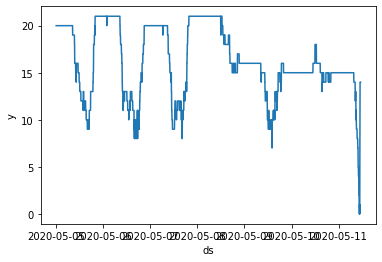

In [7]:
_ = sns.lineplot(x="ds", y="y", data=df)

In [8]:
m = Prophet()
m.fit(df)
future = m.make_future_dataframe(periods=180, freq='min')
future.tail

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.


<bound method NDFrame.tail of                       ds
0    2020-05-05 00:01:00
1    2020-05-05 00:02:00
2    2020-05-05 00:03:00
3    2020-05-05 00:04:00
4    2020-05-05 00:05:00
...                  ...
9475 2020-05-11 14:05:00
9476 2020-05-11 14:06:00
9477 2020-05-11 14:07:00
9478 2020-05-11 14:08:00
9479 2020-05-11 14:09:00

[9480 rows x 1 columns]>

In [9]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
9475,2020-05-11 14:05:00,10.291686,8.315795,12.259203
9476,2020-05-11 14:06:00,10.289158,8.165992,12.432677
9477,2020-05-11 14:07:00,10.286483,8.231394,12.378706
9478,2020-05-11 14:08:00,10.283659,8.275136,12.257419
9479,2020-05-11 14:09:00,10.280688,8.285010,12.292066


In [10]:
forecast_full = forecast
forecast_full['y'] = df['y']
# Replacing y Nan values with last values known
# forecast_full['y'].iloc[df.shape[0]:] = forecast_full['y'].iloc[df.shape[0]-1]
forecast_full['yhat_round'] = forecast_full['yhat'].apply(lambda x: round(x))

In [11]:
forecast_full.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,yhat_round
0,2020-05-05 00:01:00,19.768811,19.054823,22.785540,19.768811,19.768811,1.087159,1.087159,1.087159,1.087159,1.087159,1.087159,0.0,0.0,0.0,20.855970,20.0,21
1,2020-05-05 00:02:00,19.766400,18.942684,22.716383,19.766400,19.766400,1.082518,1.082518,1.082518,1.082518,1.082518,1.082518,0.0,0.0,0.0,20.848918,20.0,21
2,2020-05-05 00:03:00,19.763990,18.877452,22.726651,19.763990,19.763990,1.077955,1.077955,1.077955,1.077955,1.077955,1.077955,0.0,0.0,0.0,20.841945,20.0,21
3,2020-05-05 00:04:00,19.761579,18.825962,22.770523,19.761579,19.761579,1.073471,1.073471,1.073471,1.073471,1.073471,1.073471,0.0,0.0,0.0,20.835050,20.0,21
4,2020-05-05 00:05:00,19.759168,19.036072,22.766373,19.759168,19.759168,1.069065,1.069065,1.069065,1.069065,1.069065,1.069065,0.0,0.0,0.0,20.828233,20.0,21


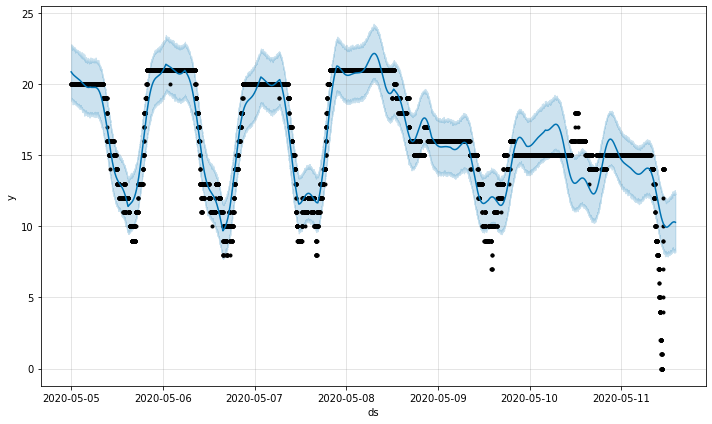

In [12]:
fig1 = m.plot(forecast)

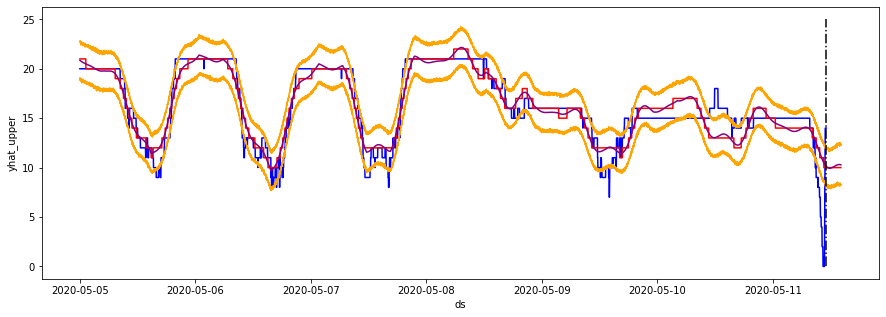

In [13]:
fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x="ds", y="y",data=forecast_full, color="blue")
sns.lineplot(x="ds", y="yhat_round",data=forecast_full, color="red")
sns.lineplot(x="ds", y="yhat",data=forecast_full, color="purple")
sns.lineplot(x="ds", y="yhat_lower",data=forecast_full, color="orange")
sns.lineplot(x="ds", y="yhat_upper",data=forecast_full, color="orange")

x1, y1 = [forecast_full.ds.iloc[df.shape[0]], forecast_full.ds.iloc[df.shape[0]]], [0, 25]
ax = plt.plot(x1, y1, linestyle="dashdot", color="black")

plt.show()


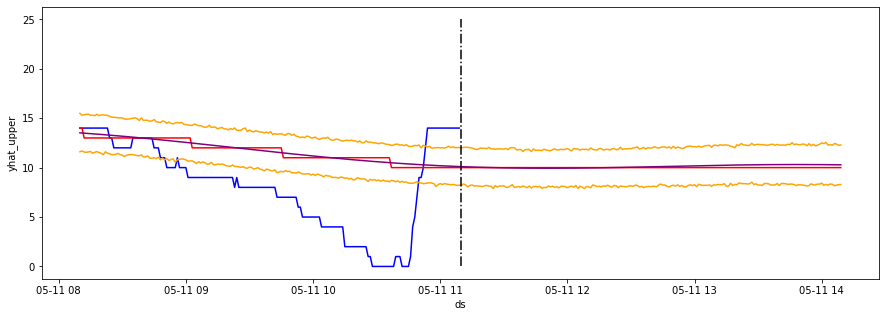

In [14]:
fig, axis = plt.subplots(figsize=(15,5))
sns.lineplot(x="ds", y="y",data=forecast_full[-180*2:], color="blue")
sns.lineplot(x="ds", y="yhat_round",data=forecast_full[-180*2:], color="red")
sns.lineplot(x="ds", y="yhat",data=forecast_full[-180*2:], color="purple")
sns.lineplot(x="ds", y="yhat_lower",data=forecast_full[-180*2:], color="orange")
sns.lineplot(x="ds", y="yhat_upper",data=forecast_full[-180*2:], color="orange")

x1, y1 = [forecast_full.ds.iloc[df.shape[0]], forecast_full.ds.iloc[df.shape[0]]], [0, 25]
ax = plt.plot(x1, y1, linestyle="dashdot", color="black")

plt.show()
